# Converting Images to Region Adjacency Graphs (RAGs)
---

## Dependencies

1. **pickle**
  - Import RAG objects
2. **numpy**
  - For calculating L1 distance between two vectors
3. **tqdm**
  - For progress bars


In [10]:
import pickle
import numpy as np
from tqdm.notebook import tqdm

## Dev Dependencies

In [59]:
import networkx as nx
from IPython.core.debugger import set_trace
from matplotlib import pyplot as plt
%matplotlib inline

---

#### Importing graph objects created earlier

In [3]:
graphs = pickle.load(open("../outputs/pickle/graphs.file", 'rb'))
print(f"{len(graphs)} loaded from file.")

1280 loaded from file.


---

### Find the Node with maximum degree

In [19]:
def get_max_degree_node(graph):
    max_degree = 0
    max_degree_node = 1
    
    for degree in graph.degree:
        if degree[1] > max_degree:
            max_degree = degree[1]
            max_degree_node = degree[0]
    
    return max_degree_node

### Priority order BFS Implemented
#### Steps
*Similar to simple BFS but Queueing is done based on volume to surface ratio*
1. Enqueue root node
2. While queue is not empty
    1. Dequeue the first element
    2. Append it the vector
    3. Get all of elements children 
    4. Enqueue them in priority order \
       (priority = area:shared boundary ratio)

In [79]:
def priority_bfs(graph, root):
    vector  = []
    visited = []
    queue   = []
    
    visited.append(root)
    queue.append(root)
    
    while queue:
        
        # Step A: Dequeue it to the vector
        current_node = queue.pop(0)
        
        
        # Step B: Append it to the vector
        vector.append(graph.nodes[current_node]['area'])
        
        # Step C: Get all of elements children 
        # Storage format : [ (<node>, <node_area>) , (<node>, <node_area>), ... ]
        current_node_neighbors = [(neighbor, graph.nodes()[neighbor]['area']) for neighbor in graph.neighbors(current_node)]
        
            
        # Step D: Sort them by their area and enqueue them
        # sorting
        current_node_neighbors.sort(key = lambda x: x[1])
        # enqueueing
        # make sure that node has not been visited first
        # althugh that should not happen since the graph is
        # always acyclic
        for neighbor in current_node_neighbors:
            if neighbor[0] not in visited:
                visited.append(neighbor[0])
                queue.append(neighbor[0])
                
    return vector      
        

### Generate vectors for each point in the trajectory

In [80]:
vectors = []
for graph in tqdm(graphs):
    # set the node with the highest edges as root
    root = get_max_degree_node(graph)
    
    # get BFS vector
    vector = priority_bfs(graph, root)
    vectors.append(vector)

### Pad all vectors such that each vector has same number of dimensions
This is useful when calculating L1 norm between each vector

In [81]:
# normalize dimensions of all vectores
max_dimension = max((map(len, vectors)))

padded_vectors = []
for vector in vectors:
    a = len(vector)
    vector += [0]*(max_dimension-len(vector))
    padded_vectors.append(np.array(vector))

### Create distance matrix

In [82]:
D_new = np.empty([len(padded_vectors), len(padded_vectors)])
for i in range(len(padded_vectors)):
    for j in range(i+1):
        D_new[i][j] = D_new[j][i] = np.linalg.norm((padded_vectors[i] - padded_vectors[j]), ord=1)
        

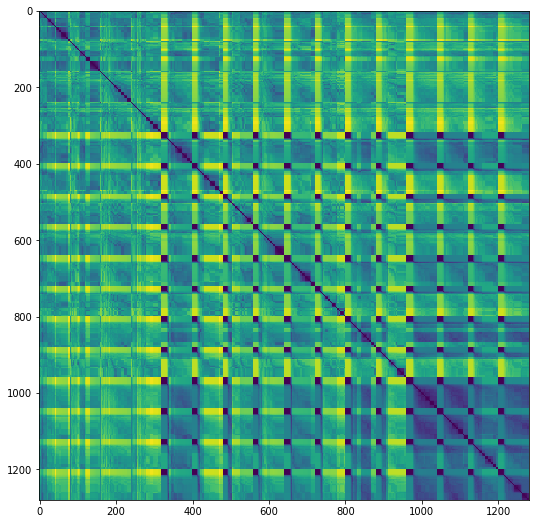

In [78]:
fig = plt.figure(figsize=(9,9))
plt.imshow(D_new)

Save the distance matrix to be used in matlab implementation of Entropy-Isomap

In [84]:
a = np.asarray(D)
np.savetxt("../outputs/distance/bfs_D.csv", a, delimiter=",")

#### Creating smaller dataset to test with Entropy-Isomap

(first 30 points of the first 2 trajectories)